In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split

from ripper_lut_net import *

In [3]:
data_dir = "data/kliegr"
dataset_file_path = os.path.join(data_dir, "hypothyroid_bin.csv")

dataset_df = pd.read_csv(dataset_file_path)
print(f"Dataset size: {dataset_df.shape}")
dataset_df

Dataset size: (3224, 21)


,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,...,tumor,hypopituitary,psych,old,male,high_tsh,low_tt4,low_t4u,low_fti,hypothyroid
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
3220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3221,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,False,False,False
3222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False


In [4]:
X = dataset_df.drop(columns=["hypothyroid"]).values
y = dataset_df["hypothyroid"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
%%time

# simple test whether it works

lut_bits = 6
num_layers = 5

ripper_net = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[32] * num_layers, verbose=True, mode='ripper')
preds_train = ripper_net.train(X_train, y_train)
preds_test = ripper_net.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Accuracy on training set: 0.97
Accuracy on test set: 0.96
CPU times: user 139 ms, sys: 193 ms, total: 331 ms
Wall time: 4.97 s


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Text(0, 0.5, 'Accuracy')

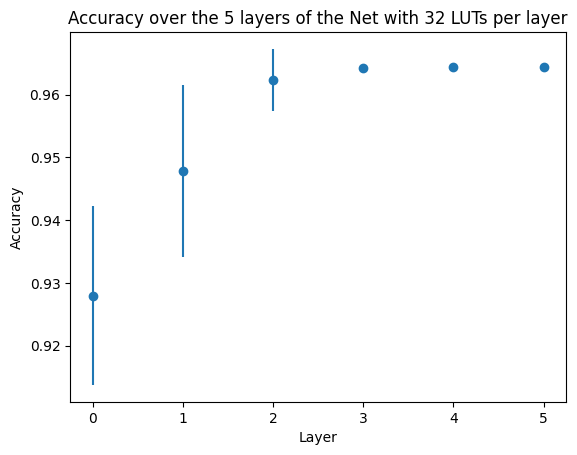

In [6]:
# experiment: accuracies over depth

num_layers = 5
num_layer_luts = 32
nums_lut_bits = 6

ripper_net = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=True, mode='ripper')
preds_train = ripper_net.train(X_train, y_train)
preds, accs = ripper_net.get_accuracies_per_layer(X_train, y_train)

mean_accs = [np.mean(acc) for acc in accs]
std_accs = [np.std(acc) for acc in accs]

# plot over layers with std
plt.errorbar(range(num_layers + 1), mean_accs, yerr=std_accs, fmt='o')
plt.title(f"Accuracy over the 5 layers of the Net with {num_layer_luts} LUTs per layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy")

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



2 LUTs per layer: Accuracy on training set: 0.92
2 LUTs per layer: Accuracy on test set: 0.91
4 LUTs per layer: Accuracy on training set: 0.95
4 LUTs per layer: Accuracy on test set: 0.95
8 LUTs per layer: Accuracy on training set: 0.96
8 LUTs per layer: Accuracy on test set: 0.96
16 LUTs per layer: Accuracy on training set: 0.96
16 LUTs per layer: Accuracy on test set: 0.97
32 LUTs per layer: Accuracy on training set: 0.97
32 LUTs per layer: Accuracy on test set: 0.96
64 LUTs per layer: Accuracy on training set: 0.97
64 LUTs per layer: Accuracy on test set: 0.96


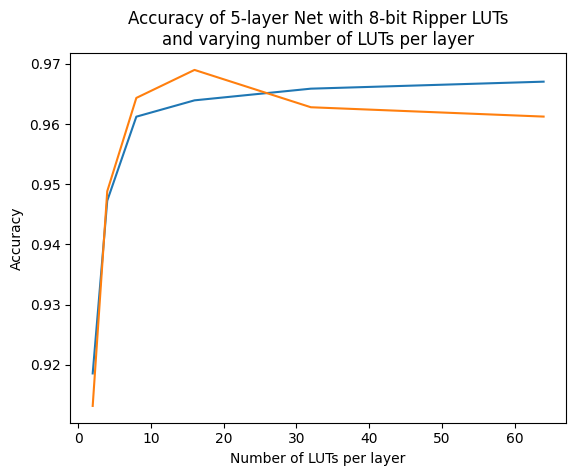

In [7]:
# experiment: accuracies with changing number of LUTs per hidden layer

num_layers = 5
nums_layer_luts = [2, 4, 8, 16, 32, 64] #, 128, 256, 512, 1024, 2048, 4096]
nums_lut_bits = 8

train_accuracies = []
test_accuracies = []
for num_layer_luts in nums_layer_luts:
    ripper_net = RipperLut(bits=[nums_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='ripper')

    preds_train = ripper_net.train(X_train, y_train)
    preds_test = ripper_net.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_layer_luts} LUTs per layer: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_layer_luts} LUTs per layer: Accuracy on test set: {test_accuracy:.2f}")
    

plt.plot(nums_layer_luts, train_accuracies, label="Train")
plt.plot(nums_layer_luts, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 8-bit Ripper LUTs\nand varying number of LUTs per layer")
plt.xlabel("Number of LUTs per layer")
plt.ylabel("Accuracy")
plt.show()

2 bits per LUT: Accuracy on training set: 0.94
2 bits per LUT: Accuracy on test set: 0.95
4 bits per LUT: Accuracy on training set: 0.97
4 bits per LUT: Accuracy on test set: 0.97
8 bits per LUT: Accuracy on training set: 0.97
8 bits per LUT: Accuracy on test set: 0.96


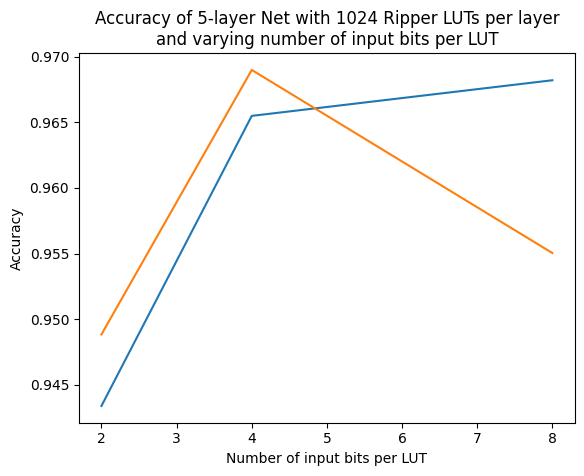

In [8]:
# experiment: accuracies with changing number of input bits per LUT

num_layers = 5
num_layer_luts = 1024
nums_lut_bits = [2, 4, 8] #, 16]

train_accuracies = []
test_accuracies = []
for num_lut_bits in nums_lut_bits:
    ripper_net = RipperLut(bits=[num_lut_bits] * (num_layers + 1), hidden_layers=[num_layer_luts] * num_layers, verbose=False, mode='ripper')

    preds_train = ripper_net.train(X_train, y_train)
    preds_test = ripper_net.predict(X_test)

    train_accuracy = accuracy_score(preds_train, y_train)
    test_accuracy = accuracy_score(preds_test, y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"{num_lut_bits} bits per LUT: Accuracy on training set: {train_accuracy:.2f}")
    print(f"{num_lut_bits} bits per LUT: Accuracy on test set: {test_accuracy:.2f}")
    
    
plt.plot(nums_lut_bits, train_accuracies, label="Train")
plt.plot(nums_lut_bits, test_accuracies, label="Test")
plt.title("Accuracy of 5-layer Net with 1024 Ripper LUTs per layer\nand varying number of input bits per LUT")
plt.xlabel("Number of input bits per LUT")
plt.ylabel("Accuracy")
plt.show()

Seems the number of input features is quite small and it performs quite good.